### Data Collection Part and Regression Model
Group Members :
1. Dileep Lingamallu
2. Abhinay Parasa
3. Krushi Teja Reddy Padamati
4. Karisma shaik

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,OrdinalEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from datetime import datetime
import urllib.request
from bs4 import BeautifulSoup
import json
from urllib.request import Request, urlopen
import numpy as np
import pandas as pd
import ssl
import requests
from statistics import mean
import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Defining Areas 

areas = ['Alameda',
         'Alamo',
         'Atherton',
         'Belmont',
         'Berkeley',
         'Burlingame',
         'Campbell',
         'Canyon',
         'Castro Valley'
         'Cupertino',
         'Daly City',
         'Danville',
         'Dublin',
         'El Cerrito',
         'Fremont',
         'Half Moon Bay',
         'Hayward',
         'Lafayette',
         'Los Altos',
         'Los Gatos',
         'Menlo Park',
         'Mill Valley',
         'Millbrae',
         'Milpitas',]

In [3]:
# This function gets the  soup object

def gethtml(url):
    
    ctx = ssl.create_default_context()
    ctx.check_hostname = False
    ctx.verify_mode = ssl.CERT_NONE
    
    header = {
    "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.169 Safari/537.36" ,}
    # Making the website believe that we are accessing website using a web browser
    req = Request(url, headers=header)
    webpage = urlopen(req).read()

    # Here we are creating a BeautifulSoup object and parsing data with lxml
    soup = BeautifulSoup(webpage, 'html.parser')
    return soup

In [4]:
# Here we are getting all uniques links for each house and saving in a data frame

zillow_df = np.nan
zillow_detail_df = True
def zillow(url,z_df = pd.DataFrame()):
    soup = gethtml(url)
    d_json = soup.find_all('script',attrs={'data-zrr-shared-data-key':"mobileSearchPageStore"})[0].string[4:-3].encode('utf8')
    data = json.loads(d_json)
    try:
        z_df = pd.DataFrame(data['cat1']['searchResults']['listResults']).loc[:,['zpid','detailUrl','hdpData']]
    except:
        z_df = z_df
    
    return z_df

In [5]:
#Here user can select number pages that are required to scrape for each area.If 2 is selected then 2 pages 
#of listimgs will be scrapped

#Scraping for the 3rd set of cities.
count = 0
pages = int(input("Select number of pages to scrape:"))
print("No of Pages to scrape Data from ",pages)
for i in areas:
    i = i.replace(" ","%20") + "-CA"
    for p in range(pages):
        link = f'https://www.zillow.com/homes/{i}/{p+1}_p'
        print(link)
        time.sleep(5)
        if count==0:
            zillow_df = zillow(link)
        else:
            zillow_df = pd.concat([zillow_df,zillow(link)],axis=0)
        count = count+1

Select number of pages to scrape:1
No of Pages to scrape Data from  1
https://www.zillow.com/homes/Los%20Altos-CA/1_p
https://www.zillow.com/homes/Los%20Gatos-CA/1_p
https://www.zillow.com/homes/Menlo%20Park-CA/1_p
https://www.zillow.com/homes/Mill%20Valley-CA/1_p
https://www.zillow.com/homes/Millbrae-CA/1_p
https://www.zillow.com/homes/Milpitas-CA/1_p


In [6]:
# Removing duplicates
zillow_df.drop_duplicates(subset = ['zpid'],keep = 'first',inplace = True)

In [7]:
# Getting house data in zillow file
c=0
for i in zillow_df['hdpData']:
    if c ==0:
        c=c+1
        zillow_detail_df = pd.DataFrame(i['homeInfo'])
    else:
        zillow_detail_df = zillow_detail_df.append(pd.DataFrame(i['homeInfo']),ignore_index=True)
                                     
zillow_detail_df.drop_duplicates(subset = ['zpid'],keep = 'first',inplace = True)
zillow_detail_df.reset_index(drop = True,inplace=True)

In [8]:
# List of fact columns that are required for analysis
req_columns = ['BuildingType',
 'CalendarYear built',
 'HeatingHeating',
 'SnowflakeCooling',
 'ParkingParking',
 'HOAHOA',
 'Price Square FeetPrice/sqft',
 'Bedrooms',
 'Bathrooms',
 'Full bathrooms',
 'Features',
 'Flooring',
 'Heating features',
 'Cooling features',
 'Appliances included',
 'Laundry features',
 'Window features',
 'Interior features',
 'Total structure area',
 'Total interior livable area',
 'Total number of fireplaces',
 'Fireplace features',
 'Total spaces',
 'Parking features',
 'Garage spaces',
 'Covered spaces',
 'Accessibility features',
 'Levels',
 'Stories',
 'Entry location',
 'Pool features',
 'Exterior features',
 'Patio and porch details',
 'View description',
 'Lot features',
 'Special conditions',
 'Home type',
 'Architectural style',
 'Property subType',
 'Construction materials',
 'Roof',
 'Property condition',
 'New construction',
 'Year built',
 'Builder name',
 'Electric information',
 'Sewer information',
 'Water information',
 'Security features',
 'Region',
 'Subdivision',
 'HOA fee',
 'Amenities included',
 'Services included',
 'Association name',
 'Association phone',
 'Price Range',
 'Listing Terms']


In [9]:
# Scrapping data for facts data using house detail link
import datetime
print(datetime.datetime.now())
facts = pd.DataFrame()#columns=req_columns)
f = {}
counter = 0
for info in zillow_df.loc[:,'detailUrl']:
    time.sleep(0.75)
    try:
        #zpid = info[-7::-1][:info[-7::-1].find("/")][::-1]
        soup = gethtml(info)
        attr = []
        vals =[]
        for k,v in json.loads(soup.find_all("script",id = "hdpApolloPreloadedData")[0].string).items():
            zpid = json.loads(v)[list(json.loads(v).keys())[1]]['property']['zpid']
            break
            
        for j in soup.find_all(['li','span'],class_=['ListItem-c11n-8-48-0__sc-10e22w8-0 dgPprD','ds-home-fact-list-item',
                                                    'Text-c11n-8-48-0__sc-aiai24-0 dQezUG','ListItem-c11n-8-65-2__sc-10e22w8-0 khvUVn',
                                                    'Text-c11n-8-65-2__sc-aiai24-0 kpJbvM',]):
            
        
            if j.text.split(":")[0] not in attr and j.text.split(":")[0] in req_columns:
                attr.append(j.text.split(":")[0])
                vals.append([j.text.split(":")[1]])
            f = zip(attr,vals)
        facts = facts.append(pd.DataFrame(dict(f),index=[zpid]),verify_integrity = True) 
    except:
        pass
    
    counter = counter +1
    print(facts.shape)
print(datetime.datetime.now())

2022-09-25 17:25:34.618805
(1, 22)
(2, 26)
(3, 34)
(4, 34)
(5, 38)
(6, 38)
(7, 38)
(8, 38)
(9, 38)
(10, 38)
(11, 38)
(12, 38)
(13, 42)
(14, 42)
(15, 42)
(16, 42)
(17, 42)
(18, 42)
(19, 42)
(20, 42)
(21, 42)
(22, 42)
(23, 42)
(24, 42)
(25, 42)
(26, 42)
(27, 42)
(28, 45)
(29, 45)
(30, 45)
(31, 45)
(32, 45)
(33, 45)
(34, 45)
(35, 46)
(36, 46)
(37, 46)
(38, 46)
(39, 46)
(40, 46)
(41, 46)
(42, 46)
(43, 46)
(44, 46)
(45, 46)
(46, 46)
(47, 46)
(48, 46)
(49, 46)
(50, 46)
(51, 47)
(52, 48)
(53, 48)
(54, 48)
(55, 48)
(56, 48)
(57, 48)
(58, 48)
(59, 48)
(60, 48)
(61, 48)
(62, 48)
(63, 48)
(64, 48)
(65, 48)
(66, 48)
(67, 48)
(68, 48)
(69, 48)
(70, 48)
(71, 48)
(72, 48)
(73, 48)
(74, 48)
(75, 48)
(76, 48)
(77, 48)
(78, 48)
(79, 48)
(80, 48)
(81, 48)
(82, 48)
(83, 48)
(84, 48)
(85, 48)
(86, 48)
(87, 48)
(88, 48)
(89, 48)
(90, 48)
(91, 50)
(92, 50)
(93, 50)
(94, 50)
(95, 50)
(96, 50)
(97, 50)
(98, 50)
(99, 50)
(100, 50)
(101, 50)
(102, 50)
(103, 50)
(104, 50)
(105, 50)
(106, 50)
(107, 50)
(108, 50)
(

In [12]:
# Saving All the files
zillow_detail_df.to_csv("Zillow3.csv")
facts.to_csv("facts3.csv")

In [13]:
import pandas as pd
import csv
data1 = pd.read_csv('zillow3.csv')
data2 = pd.read_csv('facts3.csv')

In [14]:
data2.columns = ['zpid', 'Bedrooms', 'Bathrooms', 'Full bathrooms', 'Features',
       'Flooring', 'Heating features', 'Cooling features',
       'Appliances included', 'Window features', 'Interior features',
       'Total structure area', 'Total interior livable area',
       'Total number of fireplaces', 'Fireplace features', 'Total spaces',
       'Parking features', 'Garage spaces', 'Covered spaces', 'Stories',
       'Pool features', 'View description', 'Home type', 'Architectural style',
       'Property subType', 'Roof', 'Year built', 'Sewer information',
       'Water information', 'Region', 'HOA fee', 'Amenities included',
       'Services included', 'Laundry features', 'Accessibility features',
       'Exterior features', 'Lot features', 'Patio and porch details',
       'Security features', 'Special conditions', 'Association name',
       'Price Range', 'Listing Terms', 'Construction materials',
       'Property condition', 'New construction', 'Electric information',
       'Entry location', 'Levels', 'Association phone', 'Builder name',
       'Subdivision']

In [15]:
data1

,Unnamed: 0,zpid,streetAddress,zipcode,city,state,latitude,longitude,price,bathrooms,...,lotAreaUnit,newConstructionType,videoCount,unit,datePriceChanged,priceReduction,priceChange,group_type,priceSuffix,providerListingID
0,0,19523388,120 Coronado Ave,94022,Los Altos,CA,37.385630,-122.116875,4895000.0,3.0,...,acres,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,19523259,501 Cherry Ave,94022,Los Altos,CA,37.390510,-122.117035,4250000.0,1.0,...,acres,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,19530234,931 Loraine Ave,94024,Los Altos,CA,37.355130,-122.088860,4750000.0,4.0,...,NaN,BUILDER_SPEC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,19532207,479 Rosita Ave,94024,Los Altos,CA,37.371033,-122.102690,3149000.0,2.0,...,sqft,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,19530035,1136 Miramonte Ave,94024,Los Altos,CA,37.362473,-122.087890,4495000.0,4.0,...,acres,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,214,79846145,564 Brisa Suave Cmn,95035,Milpitas,CA,37.421000,-121.910230,1489500.0,3.0,...,sqft,NaN,NaN,NaN,1.663139e+12,"$9,388 (Sep 14)",-9388.0,NaN,NaN,NaN
215,215,19478990,25 Terfidia Ln,95035,Milpitas,CA,37.438870,-121.874306,899888.0,3.0,...,sqft,NaN,NaN,NaN,1.659942e+12,"$99,612 (Aug 8)",-99612.0,NaN,NaN,NaN
216,216,2063091786,1832 Joshua Tree Cir,95035,Milpitas,CA,NaN,NaN,1516930.0,3.0,...,sqft,NEW_CONSTRUCTION_TYPE_OTHER,NaN,NaN,1.659164e+12,"$54,000 (Jul 30)",-54000.0,NaN,NaN,NaN
217,217,2063189646,1820 Joshua Tree Cir,95035,Milpitas,CA,NaN,NaN,1466930.0,3.0,...,sqft,NEW_CONSTRUCTION_TYPE_OTHER,NaN,NaN,1.659164e+12,"$15,000 (Jul 30)",-15000.0,NaN,NaN,NaN


In [16]:
#dropping the unwanted columns in the data frame
data1 = data1.drop(data1.columns[0],axis=1)
data1

,zpid,streetAddress,zipcode,city,state,latitude,longitude,price,bathrooms,bedrooms,...,lotAreaUnit,newConstructionType,videoCount,unit,datePriceChanged,priceReduction,priceChange,group_type,priceSuffix,providerListingID
0,19523388,120 Coronado Ave,94022,Los Altos,CA,37.385630,-122.116875,4895000.0,3.0,3.0,...,acres,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,19523259,501 Cherry Ave,94022,Los Altos,CA,37.390510,-122.117035,4250000.0,1.0,2.0,...,acres,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,19530234,931 Loraine Ave,94024,Los Altos,CA,37.355130,-122.088860,4750000.0,4.0,4.0,...,NaN,BUILDER_SPEC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19532207,479 Rosita Ave,94024,Los Altos,CA,37.371033,-122.102690,3149000.0,2.0,2.0,...,sqft,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19530035,1136 Miramonte Ave,94024,Los Altos,CA,37.362473,-122.087890,4495000.0,4.0,4.0,...,acres,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,79846145,564 Brisa Suave Cmn,95035,Milpitas,CA,37.421000,-121.910230,1489500.0,3.0,4.0,...,sqft,NaN,NaN,NaN,1.663139e+12,"$9,388 (Sep 14)",-9388.0,NaN,NaN,NaN
215,19478990,25 Terfidia Ln,95035,Milpitas,CA,37.438870,-121.874306,899888.0,3.0,3.0,...,sqft,NaN,NaN,NaN,1.659942e+12,"$99,612 (Aug 8)",-99612.0,NaN,NaN,NaN
216,2063091786,1832 Joshua Tree Cir,95035,Milpitas,CA,NaN,NaN,1516930.0,3.0,3.0,...,sqft,NEW_CONSTRUCTION_TYPE_OTHER,NaN,NaN,1.659164e+12,"$54,000 (Jul 30)",-54000.0,NaN,NaN,NaN
217,2063189646,1820 Joshua Tree Cir,95035,Milpitas,CA,NaN,NaN,1466930.0,3.0,3.0,...,sqft,NEW_CONSTRUCTION_TYPE_OTHER,NaN,NaN,1.659164e+12,"$15,000 (Jul 30)",-15000.0,NaN,NaN,NaN


In [17]:
data2

,zpid,Bedrooms,Bathrooms,Full bathrooms,Features,Flooring,Heating features,Cooling features,Appliances included,Window features,...,Listing Terms,Construction materials,Property condition,New construction,Electric information,Entry location,Levels,Association phone,Builder name,Subdivision
0,19523388,3.0,3.0,3.0,Formal Dining Room,Central Forced Air,None,"1,760","1,760 sqft",2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,19523259,2.0,1.0,1.0,Stall Shower,Wall Furnace,None,"1,216","1,216 sqft",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,19530234,4.0,4.0,3.0,Dining Area,"Central Forced Air, Electric",Central Air,"2,864","2,864 sqft",1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19532207,2.0,2.0,1.0,"Stall Shower, Tile, Tub","Central Forced Air, Wall Furnace",Wall/Window Unit(s),"1,430","1,430 sqft",2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19530035,4.0,4.0,3.0,Walk-In Closet(s),"Forced Air, Gas, Heating - 2+ Zones, Radiant ...","Central Air, Zoned","3,025","3,025 sqft",1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,79846145,4.0,3.0,3.0,Primary Suite / Retreat,Central Forced Air - Gas,Central Air,"2,045","2,045 sqft",NaN,...,"Common Area Electricity, Maintenance - Common...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
215,19478990,3.0,3.0,2.0,Dining Area,Central Forced Air - Gas,None,"1,428","1,428 sqft",NaN,...,"Common Area Electricity, Exterior Painting, Roof",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
216,2063091786,3.0,3.0,2.0,NaN,Zoned,"Zoned, ENERGY STAR Qualified Equipment","1,881","1,881 sqft",NaN,...,"Exterior Maintenance, Management Fee, Reserve...","Three or More Stories,Three Or More",Standard,"Builder's Lender-In-House,Cash,Conventional,O...",NaN,NaN,Toll Brothers,CALL LISTING AGENT,844-790-5263,NaN
217,2063189646,3.0,3.0,3.0,NaN,Zoned,"Zoned, ENERGY STAR Qualified Equipment","1,727","1,727 sqft",NaN,...,"Exterior Maintenance, Management Fee, Reserve...","Three or More Stories,Three Or More",Standard,"Builder's Lender-In-House,Cash,Conventional,O...",NaN,NaN,Toll Brothers,CALL LISTING AGENT,844-790-5263,NaN


In [19]:
# using merge function by setting how='inner'
# Merging the house details and the house features files together.
final3 = pd.merge(data1, data2, 
                   on='zpid', 
                   how='inner')

In [20]:
final3.to_csv('final3.csv')

In [21]:
final3 = pd.read_csv('final3.csv')
final3

,Unnamed: 0,zpid,streetAddress,zipcode,city,state,latitude,longitude,price,bathrooms,...,Listing Terms,Construction materials,Property condition,New construction,Electric information,Entry location,Levels,Association phone,Builder name,Subdivision
0,0,19523388,120 Coronado Ave,94022,Los Altos,CA,37.385630,-122.116875,4895000.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,19523259,501 Cherry Ave,94022,Los Altos,CA,37.390510,-122.117035,4250000.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,19530234,931 Loraine Ave,94024,Los Altos,CA,37.355130,-122.088860,4750000.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,19532207,479 Rosita Ave,94024,Los Altos,CA,37.371033,-122.102690,3149000.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,19530035,1136 Miramonte Ave,94024,Los Altos,CA,37.362473,-122.087890,4495000.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,214,79846145,564 Brisa Suave Cmn,95035,Milpitas,CA,37.421000,-121.910230,1489500.0,3.0,...,"Common Area Electricity, Maintenance - Common...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
215,215,19478990,25 Terfidia Ln,95035,Milpitas,CA,37.438870,-121.874306,899888.0,3.0,...,"Common Area Electricity, Exterior Painting, Roof",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
216,216,2063091786,1832 Joshua Tree Cir,95035,Milpitas,CA,NaN,NaN,1516930.0,3.0,...,"Exterior Maintenance, Management Fee, Reserve...","Three or More Stories,Three Or More",Standard,"Builder's Lender-In-House,Cash,Conventional,O...",NaN,NaN,Toll Brothers,CALL LISTING AGENT,844-790-5263,NaN
217,217,2063189646,1820 Joshua Tree Cir,95035,Milpitas,CA,NaN,NaN,1466930.0,3.0,...,"Exterior Maintenance, Management Fee, Reserve...","Three or More Stories,Three Or More",Standard,"Builder's Lender-In-House,Cash,Conventional,O...",NaN,NaN,Toll Brothers,CALL LISTING AGENT,844-790-5263,NaN


In [22]:
# data frame for the 3rd set of cities
final3 = final3.drop(final3.columns[0],axis=1)
final3

,zpid,streetAddress,zipcode,city,state,latitude,longitude,price,bathrooms,bedrooms,...,Listing Terms,Construction materials,Property condition,New construction,Electric information,Entry location,Levels,Association phone,Builder name,Subdivision
0,19523388,120 Coronado Ave,94022,Los Altos,CA,37.385630,-122.116875,4895000.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,19523259,501 Cherry Ave,94022,Los Altos,CA,37.390510,-122.117035,4250000.0,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,19530234,931 Loraine Ave,94024,Los Altos,CA,37.355130,-122.088860,4750000.0,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19532207,479 Rosita Ave,94024,Los Altos,CA,37.371033,-122.102690,3149000.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19530035,1136 Miramonte Ave,94024,Los Altos,CA,37.362473,-122.087890,4495000.0,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,79846145,564 Brisa Suave Cmn,95035,Milpitas,CA,37.421000,-121.910230,1489500.0,3.0,4.0,...,"Common Area Electricity, Maintenance - Common...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
215,19478990,25 Terfidia Ln,95035,Milpitas,CA,37.438870,-121.874306,899888.0,3.0,3.0,...,"Common Area Electricity, Exterior Painting, Roof",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
216,2063091786,1832 Joshua Tree Cir,95035,Milpitas,CA,NaN,NaN,1516930.0,3.0,3.0,...,"Exterior Maintenance, Management Fee, Reserve...","Three or More Stories,Three Or More",Standard,"Builder's Lender-In-House,Cash,Conventional,O...",NaN,NaN,Toll Brothers,CALL LISTING AGENT,844-790-5263,NaN
217,2063189646,1820 Joshua Tree Cir,95035,Milpitas,CA,NaN,NaN,1466930.0,3.0,3.0,...,"Exterior Maintenance, Management Fee, Reserve...","Three or More Stories,Three Or More",Standard,"Builder's Lender-In-House,Cash,Conventional,O...",NaN,NaN,Toll Brothers,CALL LISTING AGENT,844-790-5263,NaN


In [23]:
# Since the IP Address is blocking when we try to scrape all the cities at a time, we scrapped the data in 3 halfes,
# and joined those 3 files together here.
import pandas as pd
import glob
import os

# setting the path for joining multiple files
#final1, final2, final3 files
files = os.path.join("final*.csv")

# list of merged files returned
files = glob.glob(files)

print("Resultant CSV after joining all CSV files at a particular location...");

# joining files with concat and read_csv
merged_final = pd.concat(map(pd.read_csv, files), ignore_index=True)
print(merged_final)

Resultant CSV after joining all CSV files at a particular location...
     Unnamed: 0        zpid                   streetAddress  zipcode  \
0             0    24858229                2828 Encinal Ave    94501   
1             1    24858601                   1220 Broadway    94501   
2             2    24869286       960 Shorepoint Ct APT 309    94501   
3             3    24873242                     1 Barker Ct    94501   
4             4  2071614819   Plan 1 Plan, Lookout at Bay37    94501   
..          ...         ...                             ...      ...   
849         341    92962130              644 Glorietta Blvd    94549   
850         342  2067056615  Residence E204 Plan, The Brant    94549   
851         343  2067480104  Residence E312 Plan, The Brant    94549   
852         344    72551392                      24 Ruth Ct    94549   
853         345    18403701                     9 Joplin Ct    94549   

          city state   latitude  longitude      price  bathrooms 

In [24]:
merged_final.to_csv('Zillow_finaldata.csv')

### DATA CLEANING

In [6]:
zillow = pd.read_csv("Zillow_finaldata.csv")

In [7]:
zillow.shape

(854, 95)

In [8]:
#dropping the unnamed duplicate index column in the data frame
zillow = zillow.drop(zillow.columns[0],axis=1)


In [9]:
#dropping the unnamed duplicate index column in the data frame
zillow = zillow.drop(zillow.columns[0],axis=1)


In [10]:
zillow.shape

(854, 93)

In [11]:
zillow.describe()

,zpid,zipcode,latitude,longitude,price,bathrooms,bedrooms,livingArea,daysOnZillow,zestimate,...,datePriceChanged,priceChange,providerListingID,videoCount,Bedrooms,Bathrooms,Full bathrooms,Stories,Total number of fireplaces,Total spaces
count,8.540000e+02,854.000000,828.000000,828.000000,8.540000e+02,800.00000,807.000000,8.190000e+02,854.0,6.350000e+02,...,2.240000e+02,2.240000e+02,6.800000e+01,94.0,807.000000,798.000000,783.000000,660.00000,545.000000,737.000000
mean,4.027277e+08,94482.277518,37.614209,-122.157525,2.389569e+06,2.85375,3.453532,4.919679e+03,-1.0,2.516837e+06,...,1.656739e+12,-1.083923e+05,2.828201e+07,1.0,3.453532,2.860902,2.445722,629.54697,1.585321,2.092266
std,7.820848e+08,367.714272,0.209647,0.194352,2.925714e+06,1.38103,1.280706,5.801154e+04,0.0,2.831973e+06,...,4.200206e+10,3.195070e+05,5.070719e+06,0.0,1.280706,1.375334,1.078411,920.06031,0.876870,1.350184
min,1.545726e+07,94002.000000,37.207250,-122.569640,3.995000e+04,0.00000,0.000000,0.000000e+00,-1.0,3.366000e+05,...,1.279264e+12,-3.000000e+06,2.117749e+06,1.0,0.000000,0.000000,1.000000,0.00000,1.000000,1.000000
25%,1.843121e+07,94025.000000,37.440247,-122.300495,1.078000e+06,2.00000,3.000000,1.353000e+03,-1.0,1.125850e+06,...,1.660806e+12,-1.442500e+05,2.926004e+07,1.0,3.000000,2.000000,2.000000,1.00000,1.000000,1.000000
50%,1.967923e+07,94536.000000,37.625655,-122.110878,1.598500e+06,3.00000,3.000000,1.920000e+03,-1.0,1.728102e+06,...,1.663096e+12,-5.200000e+04,2.957266e+07,1.0,3.000000,3.000000,2.000000,2.00000,1.000000,2.000000
75%,9.215396e+07,94703.750000,37.804084,-121.988853,2.598750e+06,3.00000,4.000000,2.705500e+03,-1.0,2.828500e+06,...,1.663744e+12,-2.000000e+04,2.962470e+07,1.0,4.000000,3.000000,3.000000,1952.00000,2.000000,2.000000
max,2.146024e+09,95128.000000,37.957603,-121.844030,3.195000e+07,12.00000,10.000000,1.629144e+06,-1.0,3.094519e+07,...,1.664089e+12,9.000000e+05,2.976335e+07,1.0,10.000000,12.000000,8.000000,2023.00000,12.000000,20.000000


In [12]:
zillow.dtypes

zpid                        int64
streetAddress              object
zipcode                     int64
city                       object
state                      object
                            ...  
View description           object
Features                   object
Patio and porch details    object
Price Range                object
Subdivision                object
Length: 93, dtype: object

In [13]:
# Replace spaces and dot in column names by underscore
zillow.columns = zillow.columns.str.replace(" ", "_")
zillow.columns = zillow.columns.str.replace(".", "_")
zillow.columns = zillow.columns.str.replace(":", "_")

In [14]:
zillow.columns

Index(['zpid', 'streetAddress', 'zipcode', 'city', 'state', 'latitude',
       'longitude', 'price', 'bathrooms', 'bedrooms', 'livingArea', 'homeType',
       'homeStatus', 'daysOnZillow', 'isFeatured', 'shouldHighlight',
       'zestimate', 'rentZestimate', 'listing_sub_type', 'openHouse',
       'isUnmappable', 'isPreforeclosureAuction', 'homeStatusForHDP',
       'priceForHDP', 'open_house_info', 'isNonOwnerOccupied',
       'isPremierBuilder', 'isZillowOwned', 'currency', 'country',
       'taxAssessedValue', 'lotAreaValue', 'lotAreaUnit', 'unit',
       'datePriceChanged', 'group_type', 'priceReduction', 'priceSuffix',
       'priceChange', 'providerListingID', 'newConstructionType', 'videoCount',
       'Bedrooms', 'Bathrooms', 'Full_bathrooms', 'Flooring',
       'Heating_features', 'Cooling_features', 'Appliances_included',
       'Laundry_features', 'Total_structure_area',
       'Total_interior_livable_area', 'Fireplace_features', 'Parking_features',
       'Levels', 'Stories

In [15]:
# Dropping all the columns that does not posses any valuble information
zillow.drop(labels=['homeStatus','isFeatured','shouldHighlight','listing_sub_type','openHouse','isUnmappable',
                   'isPreforeclosureAuction','homeStatusForHDP','open_house_info','priceForHDP',
                    'isNonOwnerOccupied','isPremierBuilder','isZillowOwned','currency','country','unit','videoCount',
                    'group_type','priceSuffix','providerListingID','newConstructionType','datePriceChanged',
                    'priceChange','priceReduction'],axis=1,inplace=True)

In [16]:
zillow.shape

(854, 69)

In [17]:
##Remove duplicate records
zillow.drop_duplicates(subset = None,keep = 'first',inplace = True)
len(zillow)
zillow.drop_duplicates(subset = None,keep = 'first',inplace = True)
len(zillow)

854

In [18]:
##Remove Outliers
# Extract all numerical columns
num_cols_df = zillow.select_dtypes([np.int, np.float])
num_cols = num_cols_df.columns
num_cols

Index(['zpid', 'zipcode', 'latitude', 'longitude', 'price', 'bathrooms',
       'bedrooms', 'livingArea', 'daysOnZillow', 'zestimate', 'rentZestimate',
       'taxAssessedValue', 'lotAreaValue', 'Bedrooms', 'Bathrooms',
       'Full_bathrooms', 'Stories', 'Total_number_of_fireplaces',
       'Total_spaces'],
      dtype='object')

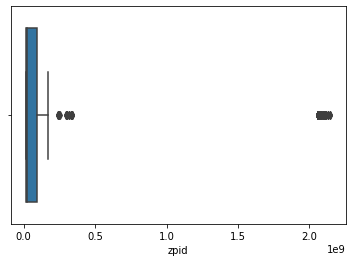

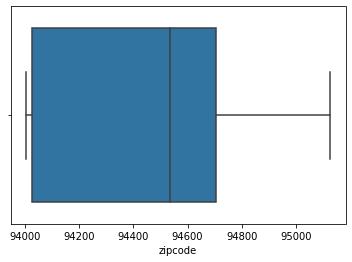

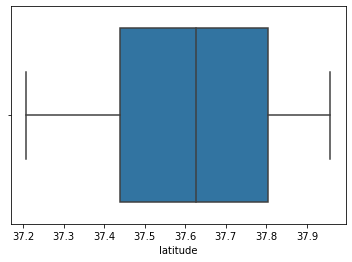

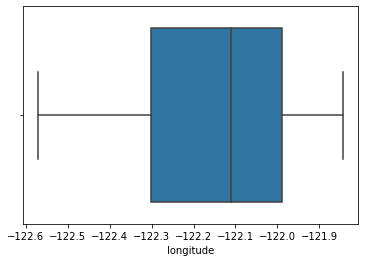

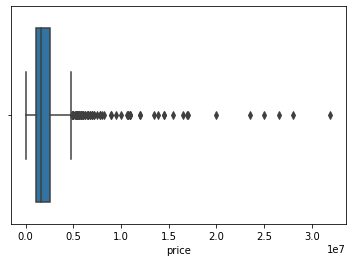

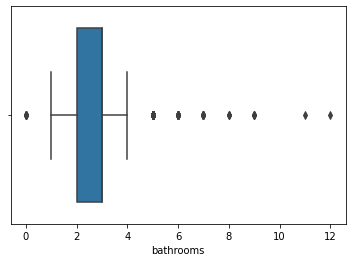

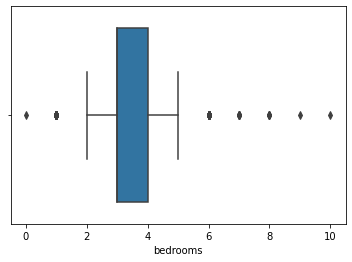

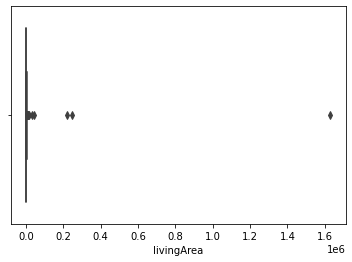

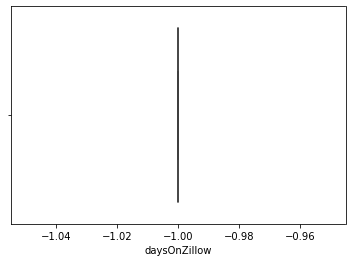

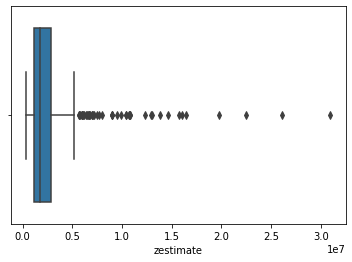

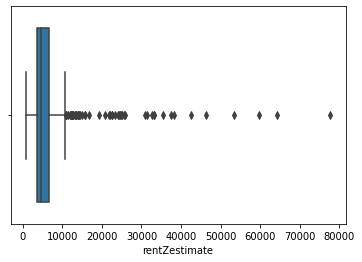

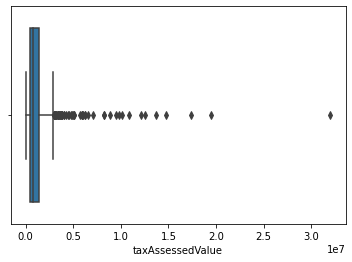

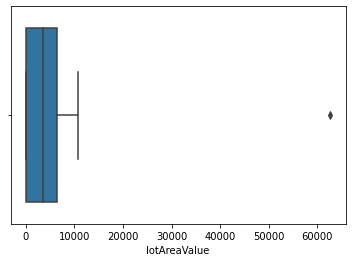

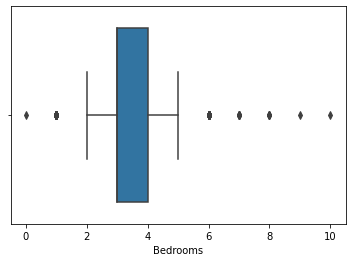

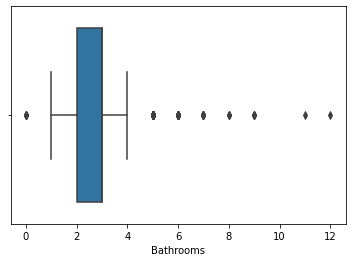

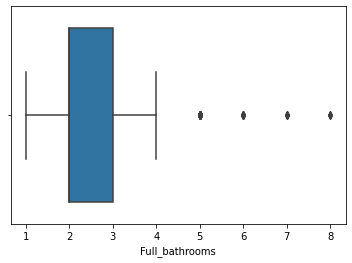

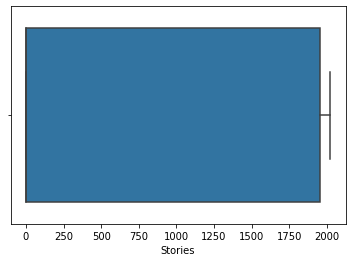

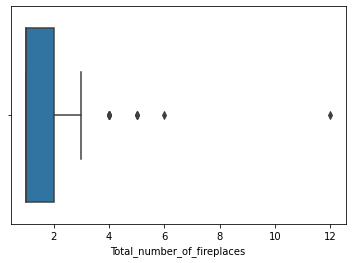

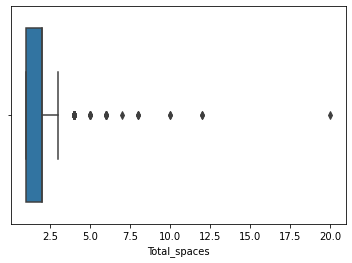

In [19]:
# Boxplot - to check outliers for all numerical columns
for col in num_cols:
    df = zillow[col]
    plt.figure()
    sns.boxplot(df)

In [20]:
# Removing outliers from all numerical columns
Q1 = zillow.quantile(0.25)
Q3 = zillow.quantile(0.75)
IQR = Q3 - Q1
no_outliers = zillow[~((zillow < (Q1 - 1.5 * IQR)) |(zillow > (Q3 + 1.5 * IQR))).any(axis=1)]

In [21]:
print( "Number of records before removing outliers:", zillow.shape)
print( "Number of records after removing outliers:", no_outliers.shape)
print(len(zillow.index) - len(no_outliers.index),"Records removed")

Number of records before removing outliers: (854, 69)
Number of records after removing outliers: (504, 69)
350 Records removed


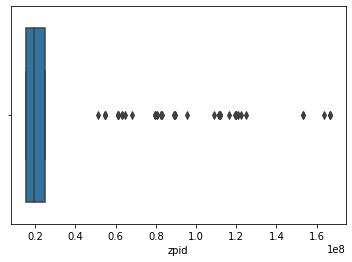

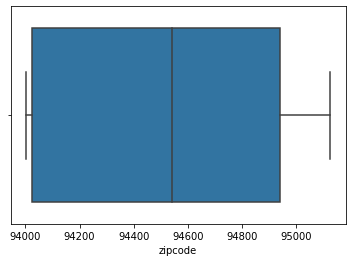

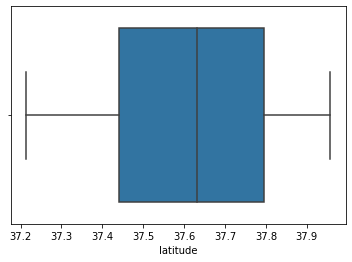

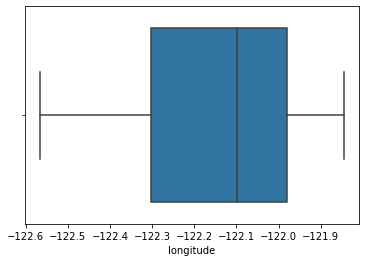

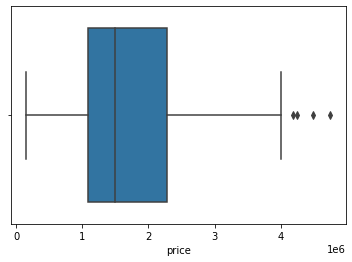

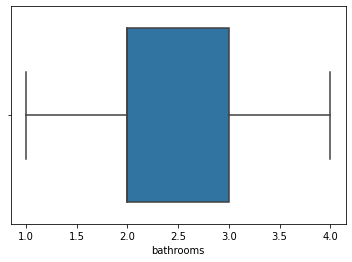

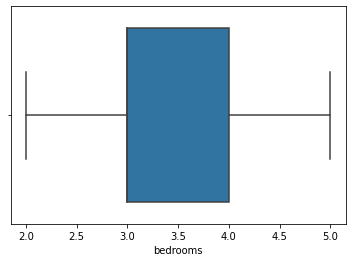

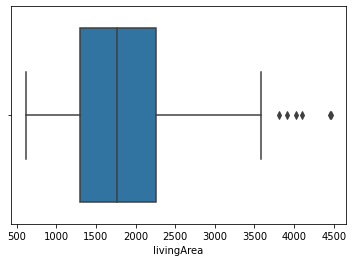

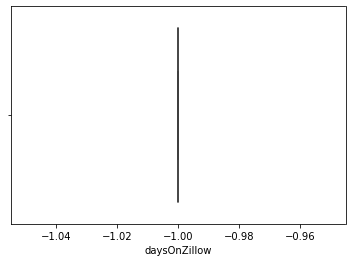

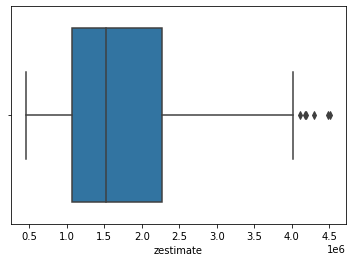

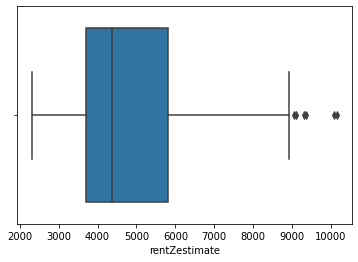

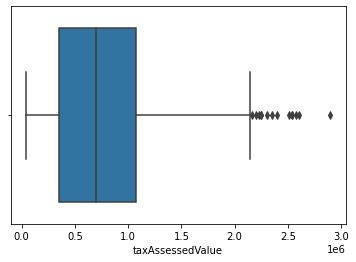

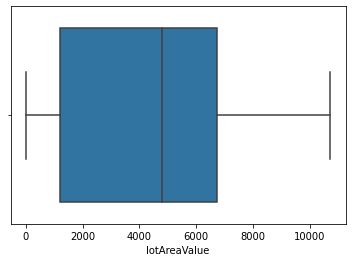

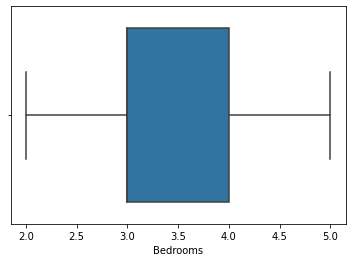

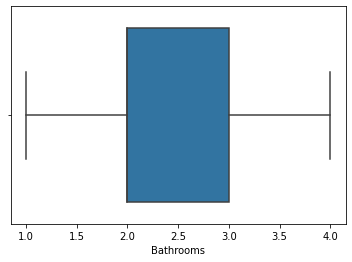

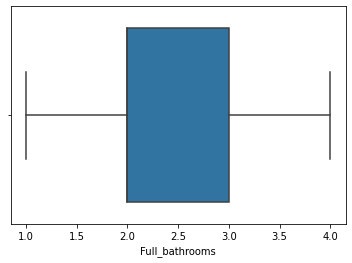

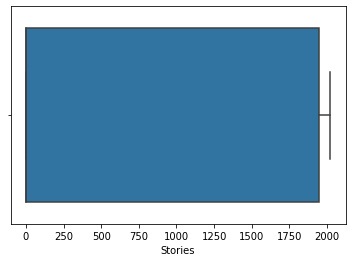

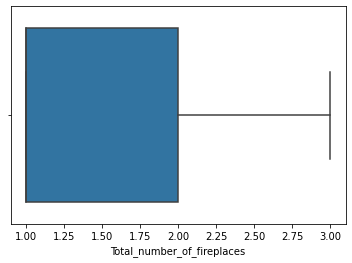

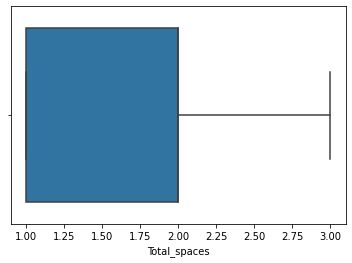

In [22]:
# Boxplot - after removing outliers for all numerical columns
for col in num_cols:
    df = no_outliers[col]
    plt.figure()
    sns.boxplot(df)

In [23]:
## Removing houses that has price greater than  7𝑀  and less than  0.1𝑀 
##We have choose 7Millions just to preserve the cities with higher prices like palo alto,Los Gatos
zillow[['price']].info()
zillow[(zillow.price <8000000) & (zillow.price>100000)]
zillow = zillow[(zillow.price <8000000) & (zillow.price>100000)]
zillow[['price']].describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 854 entries, 0 to 853
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   854 non-null    float64
dtypes: float64(1)
memory usage: 13.3 KB


,price
count,8.230000e+02
mean,1.965343e+06
std,1.348830e+06
min,1.350000e+05
25%,1.055000e+06
50%,1.575000e+06
75%,2.495000e+06
max,7.995000e+06


In [24]:
## Checking the percentage of null values in each column
##Filtering all the columns that has more than 50% of data as null.
zillow.isna().mean()
zillow = zillow.loc[:,zillow.isna().mean()<0.50]
zillow[zillow.homeType == 'MANUFACTURED']


,zpid,streetAddress,zipcode,city,state,latitude,longitude,price,bathrooms,bedrooms,...,Roof,Year_built,Sewer_information,Water_information,Region,Interior_features,Total_number_of_fireplaces,Total_spaces,Garage_spaces,Covered_spaces
216,2061538371,50 Palomar Real #50,95008,Campbell,CA,37.282223,-121.939460,449000.0,3.0,2.0,...,Metal,1967.0,Public Sewer,Public,Campbell,Wet Bar,NaN,2.0,NaN,2.0
749,2065627807,58 Seascape Dr #58,94019,Half Moon Bay,CA,37.428123,-122.427185,285000.0,2.0,2.0,...,Rolled/Hot Mop,1984.0,Public Sewer,Public,Half Moon Bay,"Storage, Vaulted Ceiling(s)",NaN,2.0,NaN,2.0
755,2112314461,130 Creekside Dr,94019,Half Moon Bay,CA,37.429230,-122.430990,559000.0,2.0,1.0,...,Metal,1976.0,Public Sewer,"Individual Water Meter, Public",Half Moon Bay,"Storage, High Ceilings, Walk-In Closet(s)",NaN,1.0,NaN,1.0
761,2062612016,20 Ocean View Ave #20,94019,Half Moon Bay,CA,37.429230,-122.430990,368000.0,2.0,2.0,...,Composition,1971.0,Public Sewer,Unknown,Half Moon Bay,Vaulted Ceiling(s),NaN,2.0,NaN,NaN
765,2062727489,49 Oceanview Ave #49,94019,Half Moon Bay,CA,37.430540,-122.429980,268000.0,1.0,2.0,...,Composition,1972.0,Public Sewer,Public,Half Moon Bay,NaN,NaN,2.0,NaN,2.0
778,2117754269,29358 Sandburg Way,94544,Hayward,CA,37.621426,-122.063354,330000.0,2.0,2.0,...,Shingle,1977.0,NaN,NaN,Hayward,"Family Room, Utility Room, Master Bedroom",NaN,NaN,NaN,NaN
799,2064016864,29048 Mendez Rd,94544,Hayward,CA,37.632730,-122.057180,298000.0,2.0,2.0,...,NaN,NaN,NaN,NaN,Hayward,"Laminate Counters, Bonus/Plus Room",NaN,2.0,NaN,NaN
800,2131653330,29011 Newcastle Ct,94544,Hayward,CA,37.622765,-122.066670,280000.0,2.0,2.0,...,NaN,NaN,NaN,NaN,Hayward,"Breakfast Bar, Laminate Counters, Kitchen/Fam...",NaN,2.0,NaN,2.0
811,2061504732,1150 W Winton Ave SPACE 540,94545,Hayward,CA,37.653015,-122.111786,249000.0,2.0,3.0,...,NaN,NaN,NaN,NaN,Hayward,"Stone Counters, Updated Kitchen, Dining Area",NaN,NaN,NaN,NaN


In [25]:
## Removing all rows with homeType as LOT and multifamily
zillow.homeType.value_counts()
zillow = zillow[~zillow.homeType.isin(['LOT','Multi-Family '])]
zillow.homeType.value_counts().sum()
## Removing all rows that has latitude or longitue or price as null
zillow[(zillow['latitude'].isna() | zillow['longitude'].isna())]
#Dropping rows that has latitue/longitude as null
zillow = zillow[(zillow.notnull()['latitude'] & zillow.notnull()['price'])]
zillow.shape

(771, 46)

In [26]:
##Replacing all the nulls in bathroom and bedroom columns with imputation
mode_impute = SimpleImputer(strategy='most_frequent')
mode_columns = ['bedrooms','bathrooms']
for i in mode_columns:
    zillow[[i]] = mode_impute.fit_transform(zillow[[i]])
zillow.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 771 entries, 0 to 853
Data columns (total 46 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   zpid                         771 non-null    int64  
 1   streetAddress                771 non-null    object 
 2   zipcode                      771 non-null    int64  
 3   city                         771 non-null    object 
 4   state                        771 non-null    object 
 5   latitude                     771 non-null    float64
 6   longitude                    771 non-null    float64
 7   price                        771 non-null    float64
 8   bathrooms                    771 non-null    float64
 9   bedrooms                     771 non-null    float64
 10  livingArea                   770 non-null    float64
 11  homeType                     771 non-null    object 
 12  daysOnZillow                 771 non-null    int64  
 13  zestimate           

In [27]:
#SimpleImputer - Replacing the nullvalues with discriptive statistic Mean, Median, Most Frequent. 
mean_columns = ['latitude','rentZestimate','lotAreaValue'] 
mean_impute = SimpleImputer(strategy='mean')
for i in mean_columns:
    zillow[[i]] = mode_impute.fit_transform(zillow[[i]])
#replacing the null values in zestimate with the values in price column
zillow['zestimate'].fillna(zillow['price'],inplace=True)
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 771 entries, 0 to 853
Data columns (total 46 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   zpid                         771 non-null    int64  
 1   streetAddress                771 non-null    object 
 2   zipcode                      771 non-null    int64  
 3   city                         771 non-null    object 
 4   state                        771 non-null    object 
 5   latitude                     771 non-null    float64
 6   longitude                    771 non-null    float64
 7   price                        771 non-null    float64
 8   bathrooms                    771 non-null    float64
 9   bedrooms                     771 non-null    float64
 10  livingArea                   770 non-null    float64
 11  homeType                     771 non-null    object 
 12  daysOnZillow                 771 non-null    int64  
 13  zestimate           

In [28]:
## Counting for number houses per city
cities = zillow[['city','zpid']].groupby(by=['city']).count().reset_index()
cities.sort_values(by=['zpid'],ascending=False)


,city,zpid
17,Hayward,41
15,Fremont,40
9,Daly City,39
20,Los Gatos,39
18,Lafayette,39
0,Alameda,39
5,Burlingame,39
4,Berkeley,39
11,Dublin,38
24,Milpitas,38


In [29]:
zillow.shape

(771, 46)

In [30]:
#dropping cities that has less than 10 houses
zillow = zillow[zillow.city.isin(cities[cities['zpid']>=10]['city'])]


In [31]:
zillow.shape

(753, 46)

In [32]:
zillow

,zpid,streetAddress,zipcode,city,state,latitude,longitude,price,bathrooms,bedrooms,...,Roof,Year_built,Sewer_information,Water_information,Region,Interior_features,Total_number_of_fireplaces,Total_spaces,Garage_spaces,Covered_spaces
0,24858229,2828 Encinal Ave,94501,Alameda,CA,37.758290,-122.23754,898000.0,1.0,2.0,...,Shingle,1900.0,Public Sewer,Public,Alameda,NaN,NaN,NaN,NaN,NaN
1,24858601,1220 Broadway,94501,Alameda,CA,37.759453,-122.24122,998000.0,2.0,3.0,...,Shingle,1910.0,Public Sewer,Public,Alameda,Counter - Solid Surface,1.0,2.0,1.0,1.0
2,24869286,960 Shorepoint Ct APT 309,94501,Alameda,CA,37.762560,-122.26949,639000.0,2.0,2.0,...,NaN,1972.0,NaN,Public,Alameda,"Elevator, Laminate Counters",NaN,1.0,1.0,1.0
3,24873242,1 Barker Ct,94501,Alameda,CA,37.781400,-122.27438,1198800.0,3.0,3.0,...,Shingle,1998.0,Public Sewer,Public,Alameda,"Dining Area, Kitchen/Family Combo, Stone Coun...",1.0,2.0,2.0,2.0
4,2071614819,"Plan 1 Plan, Lookout at Bay37",94501,Alameda,CA,37.789710,-122.27929,778990.0,2.0,1.0,...,NaN,NaN,NaN,NaN,Alameda,NaN,NaN,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
849,92962130,644 Glorietta Blvd,94549,Lafayette,CA,37.883698,-122.15426,2595000.0,4.0,5.0,...,Shingle,1979.0,Public Sewer,NaN,Lafayette,"Solarium, Counter - Solid Surface, Eat-in Kit...",3.0,5.0,2.0,2.0
850,2067056615,"Residence E204 Plan, The Brant",94549,Lafayette,CA,37.889000,-122.13240,1880880.0,3.0,3.0,...,NaN,NaN,NaN,NaN,Lafayette,NaN,NaN,2.0,NaN,NaN
851,2067480104,"Residence E312 Plan, The Brant",94549,Lafayette,CA,37.889000,-122.13240,1745880.0,3.0,3.0,...,NaN,NaN,NaN,NaN,Lafayette,NaN,NaN,2.0,NaN,NaN
852,72551392,24 Ruth Ct,94549,Lafayette,CA,37.895508,-122.08577,3895000.0,6.0,5.0,...,Composition,2006.0,Public Sewer,Public,Lafayette,"Kitchen Island, Pantry, Updated Kitchen",4.0,3.0,3.0,3.0


In [33]:
# Our final csv file of the scrapped data after cleaning
zillow.to_csv('Zillow_clean.csv')

In [37]:
#merging all the rating files into 1 file

import pandas as pd
import glob
import os

# setting the path for joining multiple files
#final1, final2, final3 files
files = os.path.join("ratings*.csv")

# list of merged files returned
files = glob.glob(files)

print("Resultant CSV after joining all CSV files at a particular location...");

# joining files with concat and read_csv
merged_ratings = pd.concat(map(pd.read_csv, files), ignore_index=True)
print(merged_ratings)

Resultant CSV after joining all CSV files at a particular location...
       Unnamed: 0  Livability Cost of Living Crime Employment Housing Schools  \
0         Alameda          74              F    D+          B      B-       B   
1           Alamo          81              F     A         A+       D      A+   
2        Atherton          76              F     B         A+       D      A+   
3         Belmont          79              F    B+          A      C-       A   
4        Berkeley          67              F     F         B-       D       A   
5      Burlingame          81              F     D          A       B       A   
6        Campbell          78              F    D+         A-      B-      A-   
7   Castro Valley          74              F    B-         B-      D+      B+   
8       Cupertino          86              F    A+         A+      D+      A+   
9       Daly City          84              F    A+          A       C      A+   
10       Danville          80          

In [38]:
merged_ratings.to_csv('ratings_final.csv')

In [39]:
ratings = pd.read_csv('ratings_final.csv')
ratings.fillna('B',inplace=True)
ratings.drop_duplicates(subset=ratings.columns,inplace = True)
ratings.drop(['Cost of Living','Amenities','User Ratings'],inplace=True,axis = 1)
ratings.head()

,Unnamed: 0.1,Unnamed: 0,Livability,Crime,Employment,Housing,Schools
0,0,Alameda,74,D+,B,B-,B
1,1,Alamo,81,A,A+,D,A+
2,2,Atherton,76,B,A+,D,A+
3,3,Belmont,79,B+,A,C-,A
4,4,Berkeley,67,F,B-,D,A


In [40]:
#dropping the unwanted columns in the df
ratings = ratings.drop(ratings.columns[0],axis=1)

In [47]:
#renaming the unnamed column in the df to city to use it later to merge the ratings and zillow data file

ratings.rename(columns = {'Unnamed: 0':'city'}, inplace = True)

In [48]:
#checking the changed column
ratings.columns[0]

'city'

In [50]:
ratings.to_csv('ratings.csv')


In [57]:
#merging the ratings and zillow file

zillow = pd.read_csv('UpdatedZillow.csv')
main_df = pd.merge(left=zillow,right=ratings,how='inner',left_on='city',right_on='city',copy=False)

In [58]:
main_df.to_csv('updated_final.csv')

In [83]:
main = pd.read_csv('updated_final.csv')
main.columns

Index(['Unnamed: 0', 'S.no', 'zpid', 'streetAddress', 'zipcode', 'city',
       'state', 'latitude', 'longitude', 'price', 'bathrooms', 'bedrooms',
       'livingArea', 'homeType', 'daysOnZillow', 'zestimate', 'rentZestimate',
       'taxAssessedValue', 'lotAreaValue', 'lotAreaUnit', 'Bedrooms',
       'Bathrooms', 'Full_bathrooms', 'Flooring', 'Heating_features',
       'Cooling_features', 'Appliances_included', 'Laundry_features',
       'Total_structure_area', 'Total_interior_livable_area',
       'Fireplace_features', 'Parking_features', 'Stories', 'Pool_features',
       'Lot_features', 'Home_type', 'Architectural_style', 'Property_subType',
       'Roof', 'Year_built', 'Sewer_information', 'Water_information',
       'Region', 'Interior_features', 'Total_number_of_fireplaces',
       'Total_spaces', 'Garage_spaces', 'Covered_spaces', 'Livability',
       'Crime', 'Employment', 'Housing', 'Schools'],
      dtype='object')

In [84]:
#manipulating columns and adding new columns explaining if the feature is availble or not 

main['HasFlooring'] = main['Flooring'].apply(lambda x: 'Yes' if x not in ['None','See Remarks',np.NAN] else 'No')

main['HasLaundary'] = main['Laundry_features'].apply(lambda x: 'Yes' if x not in ['None','See Remarks',np.NAN] else 'No')

main['HasPool'] = main['Pool_features'].apply(lambda x: 'Yes' if x not in ['None','See Remarks',np.NAN] else 'No')

main['HasHeating'] = main['Heating_features'].apply(lambda x: 'Yes' if x not in ['None','See Remarks',np.NAN] else 'No')

main['HasCooling'] = main['Cooling_features'].apply(lambda x: 'Yes' if x not in ['None','See Remarks',np.NAN] else 'No')

main['Price/sqft'] = main['price']/main['livingArea']

main['HasGarageSpace'] = main['Garage_spaces'].apply(lambda x: 'Yes' if x not in ['None', np.NaN] else 'No')

main['HasFirePlace'] = main['Total_number_of_fireplaces'].apply(lambda x: 'Yes' if x not in ['None', np.NaN] else 'No')



In [113]:
main.columns

Index(['Unnamed: 0', 'S.no', 'zpid', 'streetAddress', 'zipcode', 'city',
       'state', 'latitude', 'longitude', 'price', 'bathrooms', 'bedrooms',
       'livingArea', 'homeType', 'daysOnZillow', 'zestimate', 'rentZestimate',
       'taxAssessedValue', 'lotAreaValue', 'lotAreaUnit', 'Bedrooms',
       'Bathrooms', 'Full_bathrooms', 'Flooring', 'Heating_features',
       'Cooling_features', 'Appliances_included', 'Laundry_features',
       'Total_structure_area', 'Total_interior_livable_area',
       'Fireplace_features', 'Parking_features', 'Stories', 'Pool_features',
       'Lot_features', 'Home_type', 'Architectural_style', 'Property_subType',
       'Roof', 'Year_built', 'Sewer_information', 'Water_information',
       'Region', 'Interior_features', 'Total_number_of_fireplaces',
       'Total_spaces', 'Garage_spaces', 'Covered_spaces', 'Livability',
       'Crime', 'Employment', 'Housing', 'Schools', 'HasFlooring',
       'HasLaundary', 'HasPool', 'HasHeating', 'HasCooling', 'Price

In [114]:
main.to_csv('regmain.csv')

In [70]:
#dropping duplicates and unwanted columns
main.drop(['Unnamed: 0', 'S.no','Flooring','Laundry_features','Pool_features','Heating_features','Cooling_features']
              ,inplace = True,axis = 1)

In [103]:
reg_main = main[['city','price','bathrooms','bedrooms','livingArea','homeType','taxAssessedValue',
                 'Price/sqft','HasFlooring','HasHeating','HasCooling','HasGarageSpace','HasLaundary',
                 'HasFirePlace','HasPool','Employment','Schools']]

In [110]:
reg_main

,city,price,bathrooms,bedrooms,livingArea,homeType,taxAssessedValue,Price/sqft,HasFlooring,HasHeating,HasCooling,HasGarageSpace,HasLaundary,HasFirePlace,HasPool,Employment,Schools
0,Alameda,898000,1,2,1000.0,SINGLE_FAMILY,635315.0,898.000000,Yes,Yes,Yes,Yes,Yes,Yes,Yes,B,B
1,Alameda,998000,2,3,1834.0,SINGLE_FAMILY,404790.0,544.165758,Yes,Yes,Yes,Yes,Yes,Yes,Yes,B,B
2,Alameda,639000,2,2,1043.0,CONDO,438482.0,612.655801,Yes,Yes,Yes,Yes,Yes,Yes,Yes,B,B
3,Alameda,1198800,3,3,1622.0,SINGLE_FAMILY,923895.0,739.087546,Yes,Yes,Yes,Yes,Yes,Yes,Yes,B,B
4,Alameda,778990,2,1,1000.0,TOWNHOUSE,NaN,778.990000,No,No,No,Yes,No,Yes,No,B,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,Lafayette,2595000,4,5,4092.0,SINGLE_FAMILY,754285.0,634.164223,Yes,Yes,Yes,Yes,Yes,Yes,Yes,B-,C
749,Lafayette,1880880,3,3,2016.0,CONDO,NaN,932.976190,No,No,No,Yes,No,Yes,No,B-,C
750,Lafayette,1745880,3,3,1795.0,CONDO,NaN,972.635097,No,No,No,Yes,No,Yes,No,B-,C
751,Lafayette,3895000,6,5,3987.0,SINGLE_FAMILY,2492587.0,976.925006,Yes,Yes,Yes,Yes,Yes,Yes,Yes,B-,C


### Regression Model

<AxesSubplot:>

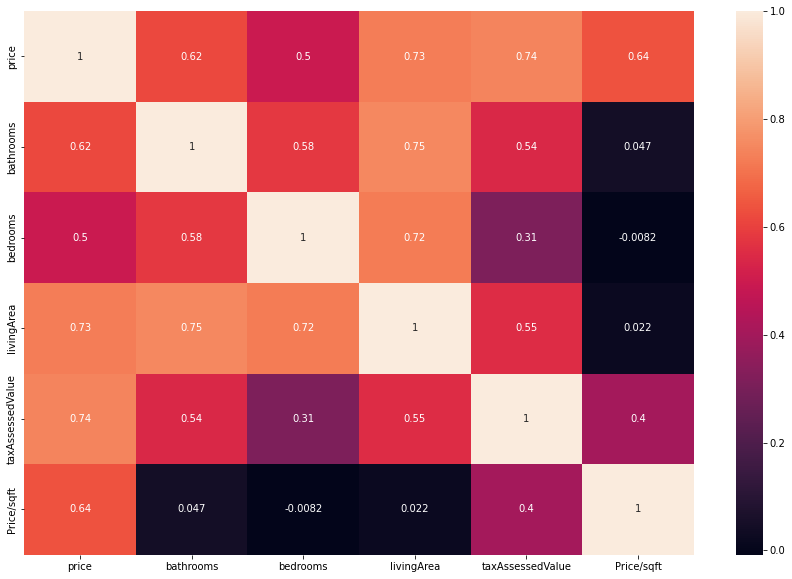

In [105]:
plt.figure(figsize=(15,10))
sns.heatmap(reg_main.corr(),annot=True)

In [107]:
y = reg_main[['price']]
X = reg_main.drop('price',axis = 1)

In [108]:
ratings_dict = {'F':1,'D-':2,'D':3,'D+':4,'C-':5,'C':6,'C+':7,
                             'B-':8,'B':9,'B+':10,'A-':11,'A':12,'A+':13}

In [111]:
city_avgdf = main_df[['city','price']].groupby(by = ['city']).mean().reset_index().sort_values(by = ['price'])
city_avgdf['ranks'] = city_avgdf['price'].rank()
city_dict = dict(zip(city_avgdf.city.values,city_avgdf.ranks.values.astype(np.int)))

In [115]:
X.Schools = X['Schools'].map(ratings_dict)
X.Employment = X['Employment'].map(ratings_dict)
X.city = X['city'].map(city_dict)

In [154]:
for i in ['HasFlooring','HasHeating','HasCooling','HasLaundary','HasPool','HasGarageSpace','HasFirePlace']:
    X[i] = X[i].map({'Yes':1,'No':0})

In [155]:
encoder = OrdinalEncoder()
onehot = OneHotEncoder()

ct = ColumnTransformer(transformers=[("encoder",encoder,['HasFlooring','HasHeating','HasCooling','HasLaundary','HasPool','HasGarageSpace','HasFirePlace']),
                                    ("onehot",onehot,['homeType'])],
                 remainder='passthrough',verbose=True)

In [156]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)

In [157]:
from xgboost import XGBRegressor

scale = StandardScaler()

model = XGBRegressor(random_state = 1,n_jobs = -1,learning_rate=0.05,n_estimators = 75,max_depth = 5)

In [158]:
from sklearn.pipeline import Pipeline

pipeline1 = Pipeline(steps=[('columntranformer',ct),('scaler',scale),('model',model)])

In [159]:
pipeline1.fit(X_train,y_train)

[ColumnTransformer] ....... (1 of 3) Processing encoder, total=   0.0s
[ColumnTransformer] ........ (2 of 3) Processing onehot, total=   0.0s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


Pipeline(steps=[('columntranformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder', OrdinalEncoder(),
                                                  ['HasFlooring', 'HasHeating',
                                                   'HasCooling', 'HasLaundary',
                                                   'HasPool', 'HasGarageSpace',
                                                   'HasFirePlace']),
                                                 ('onehot', OneHotEncoder(),
                                                  ['homeType'])],
                                   verbose=True)),
                ('scaler', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=0.5, booster='g...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.05, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=5, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=75, n_jobs=-1, num_parallel_tree=1,
                              predictor='auto', random_state=1, reg_alpha=0,
                              reg_lambda=1, ...))])

In [160]:
pipeline1.predict(X_test)

array([1172492.6 ,  678976.4 , 3725915.8 , 2612645.  , 2149156.  ,
       1153423.1 ,  862527.2 , 2095175.1 , 1150396.5 , 1327312.8 ,
       1040093.3 , 2046576.2 ,  975596.8 ,  981638.56, 2758084.8 ,
       1232190.9 , 1645054.6 , 2811548.8 , 6256166.  , 2494717.5 ,
       3037639.2 , 1201747.1 , 1232190.9 , 2604614.8 , 1034584.7 ,
        791924.56,  749932.9 ,  880038.8 , 1289481.8 , 1045253.6 ,
       1624318.4 , 4131661.5 , 1403666.9 ,  929020.8 , 1534418.1 ,
        906039.56, 1071333.9 , 2810281.5 ,  841395.06, 1255496.9 ,
       3073292.  , 1144555.5 , 1496700.  ,  764334.56,  294101.03,
        771047.6 , 1400613.2 , 1046898.7 , 1178573.9 , 2611031.2 ,
       1271887.6 , 3081503.8 ,  727202.25, 1120517.5 ,  676105.9 ,
       1326416.5 , 4767124.5 ,  626685.3 , 2553875.5 , 2000837.1 ,
        617188.8 , 2255881.5 , 2303519.8 , 1072902.8 , 4554159.5 ,
       1332927.  , 1794353.4 , 1258789.  , 1299974.5 , 2131051.  ,
       2013337.5 ,  974457.8 ,  768657.7 , 1120517.5 ,  880038

In [161]:
X_test.to_csv('testing.csv')

In [147]:
pred = pd.DataFrame(pipeline1.predict(X_test),index=X_test.index,columns = ['Predicted'])

In [148]:
zest = pd.DataFrame(main_df.zestimate,index=X_test.index)

In [149]:
zest

,zestimate
719,1295300
449,699686
60,3288003
161,2795021
389,2204916
...,...
195,1199000
223,697919
746,1610880
160,1374100


In [150]:
compare_df = pd.concat((y_test,round(pred),zest),axis = 1)
compare_df.head(10)

,price,Predicted,zestimate
719,1225000,1172493.0,1295300
449,698000,678976.0,699686
60,3288000,3725916.0,3288003
161,2795000,2612645.0,2795021
389,2085000,2149156.0,2204916
656,1199000,1153423.0,1185000
286,899000,862527.0,895300
120,1995000,2095175.0,1995000
480,1198000,1150396.0,1205933
570,1349000,1327313.0,1349000


In [151]:
residuals_test = compare_df['price'] - compare_df['Predicted']
residuals_test

719     52507.0
449     19024.0
60    -437916.0
161    182355.0
389    -64156.0
         ...   
195    -18278.0
223    -41777.0
746     22570.0
160     69603.0
701    -77913.0
Length: 189, dtype: float64